In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
import wave
import math
import os
import matplotlib.pyplot as plt
from scipy.io import wavfile
import python_speech_features as psf
import vad_utils as vad
import evaluate as eva

"""
已知音频文件采样率均为16kHz
取帧长度32ms : frame_length = 512
取帧移8ms : step = 128
"""

# 路径
dev_wav_path = "../vad/wavs/dev"
train_wav_path = "../vad/wavs/train"
label_path = "../vad/data"

# 读label文件
dev_label_data = vad.read_label_from_file(label_path + "/dev_label.txt")
train_label_data = vad.read_label_from_file(label_path + "/train_label.txt")
print("Read label success")

# 读取文件夹
dev_files = os.listdir(dev_wav_path)
train_files = os.listdir(train_wav_path)
print("Read files success")


Read label success
Read files success


In [2]:
# total_frames = 0

voice_features = []
nonvoice_features = []
# print("List initialize success")

for file in train_files:
    # 读取当前wav的label
    current_label_data = train_label_data[file[0:-4]]
    # 读取当前wav文件
    sample_rate, wav_data = wavfile.read(train_wav_path + "/" + file)

    # print("Processing " + train_wav_path + "/" + file)

    wav_vector = psf.base.mfcc(wav_data, 16000, 0.032, 0.008)

    # 计算帧数
    L = len(wav_data)
    num_of_steps = np.asarray(np.ceil((L - 512) / 128) + 1, dtype=int)

    # total_frames += num_of_steps

    # print(num_of_steps)
    # print(len(wav_vector))

    # 时间轴
    time = np.zeros(num_of_steps)
    for i in range(num_of_steps):
        time[i] = (i * 128 + 256) / 16000
    
    # 补零
    current_label_data = train_label_data[file[0:-4]]
    current_label_data = list(current_label_data) + list(
        np.zeros(len(time) - len(current_label_data))
    )

    for i in range(num_of_steps):
        if current_label_data[i] == 1:
            # 标记为语音片段的帧
            voice_features.append(wav_vector[i])
        else:
            # 标记为非语音片段的帧
            nonvoice_features.append(wav_vector[i])
    
    # print(wav_vector)
    # print(np.array(wav_vector).shape)
    # break


In [3]:
# 语音片段
print(len(voice_features))
# voice_features = np.vstack((voice_features, voice_vector))
# 非语音片段
print(len(nonvoice_features))
# nonvoice_features = np.vstack((voice_features, nonvoice_vector))



5168743
1181335


In [4]:
print("\nTraining voice GMM...\n")
voice_gmm = GaussianMixture(n_components=50)
voice_gmm.fit(voice_features)
print("Voice GMM converged: ")
print(voice_gmm.converged_)

print("\nTraining non-voice GMM...\n")
nonvoice_gmm = GaussianMixture(n_components=50)
nonvoice_gmm.fit(nonvoice_features)
print("Nonvoice GMM converged: ")
print(nonvoice_gmm.converged_)


Training voice GMM...

Voice GMM converged: 
True

Training voice GMM...

Nonvoice GMM converged: 
True


In [5]:
def get_acc(prediction, actual):
    """
    input:
        prediction 预测list eg.[0,0,1,0,...,1,0]
        actual 从实际label文件中读取的list
    return:
        acc accuracy
    """
    total_frame = len(actual)
    correct_frame = 0

    for i in range(total_frame):
        if prediction[i] == actual[i]:
            correct_frame += 1
    acc = correct_frame / total_frame

    return acc

In [6]:
"""
    /dev
    开发集
    所有不随循环消亡的变量均带dev_前缀
"""

# 创建输出文件
dev_output = open("dev_output.txt", "w")

# 用于计算AUC、EER、ROC等指标的变量，不随循环消亡
dev_reserve_for_cal = []
dev_label_for_cal = []

# 读取开发集label，返回dict
dev_label_data = vad.read_label_from_file(label_path + "/dev_label.txt")

for file in dev_files:
    sample_rate, wav_data = wavfile.read(dev_wav_path + "/" + file)

    # print("Processing " + dev_wav_path + "/" + file)

    vectors = psf.base.mfcc(wav_data, sample_rate, 0.032, 0.008)

    # # 计算两个模型下的predict
    # voice_predict = np.array(voice_gmm.predict(vectors))
    # non_predict = np.array(nonvoice_gmm.predict(vectors))

    # 计算两个模型下的scores
    voice_score_samples = np.array(voice_gmm.score_samples(vectors))
    non_score_samples = np.array(nonvoice_gmm.score_samples(vectors))

    # print(voice_score_samples)
    # print(non_score_samples)
    # print(len(voice_score))
    # print(len(non_score))

    # 计算帧数，帧数、两个predict的长度应都相同
    L = len(wav_data)
    num_of_steps = np.asarray(np.ceil((L - 512) / 128) + 1, dtype=int)
    # print(num_of_steps)

    # 时间轴
    time = np.zeros(num_of_steps)
    for i in range(num_of_steps):
        time[i] = (i * 128 + 256) / 16000

    # 补零
    current_label_data = dev_label_data[file[0:-4]]
    current_label_data = list(current_label_data) + list(
        np.zeros(len(time) - len(current_label_data))
    )
    # print(len(current_label_data))

    # 保存label
    for i in range(len(current_label_data)):
        dev_label_for_cal.append(current_label_data[i])
    # print(len(dev_label_for_cal))
    
    # 定义并初始化保存单个wav文件中各帧prediction的list
    result = []

    # 取大
    for i in range(len(voice_score_samples)):
        if voice_score_samples[i] >= non_score_samples[i]:
            result.append(1)
            dev_reserve_for_cal.append(1)
        else:
            result.append(0)
            dev_reserve_for_cal.append(0)

    dev_label = []
    dev_label = vad.prediction_to_vad_label(result)

    dev_output.write(file[0:-4] + " " + dev_label + "\n")

dev_output.close()
print("\nComplete!\nResult file generated as dev_output.txt\n")



Complete!
Result file generated as dev_output.txt




Calculating AUC, EER, TPR, FPR, Threshold of dev dataset...

AUC =  0.9418757044462838
EER =  0.06937562633193536
TPR =  [0.         0.93062437 1.        ]
FPR =  [0.         0.04687296 1.        ]
ACC =  0.9347531677694396


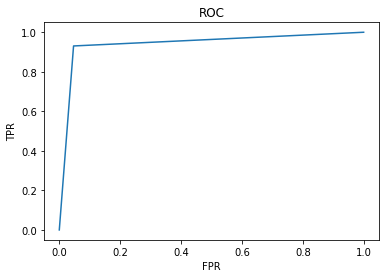

In [7]:
print("\nCalculating AUC, EER, TPR, FPR, Threshold of dev dataset...\n")
auc, eer, tpr, fpr, thres = eva.get_metrics(dev_reserve_for_cal, dev_label_for_cal)
print("AUC = ", auc)
print("EER = ", eer)
print("TPR = ", tpr)
# print(tpr.shape)
print("FPR = ", fpr)
# print(fpr.shape)
# print("Threshold = ", thres)

dev_acc = get_acc(dev_reserve_for_cal, dev_label_for_cal)
print("ACC = ", dev_acc)

plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.savefig("dev_ROC.png")
plt.show()

In [8]:
"""
    /train
    训练集
    所有不随循环消亡的变量均带train_前缀
"""

# 创建输出文件
train_output = open("train_output.txt", "w")

# 用于计算AUC、EER、ROC等指标的变量，不随循环消亡
train_reserve_for_cal = []
train_label_for_cal = []

# 读取开发集label，返回dict
train_label_data = vad.read_label_from_file(label_path + "/train_label.txt")

for file in train_files:
    sample_rate, wav_data = wavfile.read(train_wav_path + "/" + file)

    # print("Processing " + train_wav_path + "/" + file)

    vectors = psf.base.mfcc(wav_data, sample_rate, 0.032, 0.008)

    # # 计算两个模型下的predict
    # voice_predict = np.array(voice_gmm.predict(vectors))
    # non_predict = np.array(nonvoice_gmm.predict(vectors))

    # 计算两个模型下的scores
    voice_score_samples = np.array(voice_gmm.score_samples(vectors))
    non_score_samples = np.array(nonvoice_gmm.score_samples(vectors))

    # print(voice_score_samples)
    # print(non_score_samples)
    # print(len(voice_score))
    # print(len(non_score))

    # 计算帧数，帧数、两个predict的长度应都相同
    L = len(wav_data)
    num_of_steps = np.asarray(np.ceil((L - 512) / 128) + 1, dtype=int)
    # print(num_of_steps)

    # 时间轴
    time = np.zeros(num_of_steps)
    for i in range(num_of_steps):
        time[i] = (i * 128 + 256) / 16000

    # 补零
    current_label_data = train_label_data[file[0:-4]]
    current_label_data = list(current_label_data) + list(
        np.zeros(len(time) - len(current_label_data))
    )
    # print(len(current_label_data))

    # 保存label
    for i in range(len(current_label_data)):
        train_label_for_cal.append(current_label_data[i])
    # print(len(train_label_for_cal))
    
    # 定义并初始化保存单个wav文件中各帧prediction的list
    result = []

    # 取大
    for i in range(len(voice_score_samples)):
        if voice_score_samples[i] >= non_score_samples[i]:
            result.append(1)
            train_reserve_for_cal.append(1)
        else:
            result.append(0)
            train_reserve_for_cal.append(0)

    train_label = []
    train_label = vad.prediction_to_vad_label(result)

    train_output.write(file[0:-4] + " " + train_label + "\n")

train_output.close()
print("\nComplete!\nResult file generated as train_output.txt\n")



Complete!
Result file generated as train_output.txt




Calculating AUC, EER, TPR, FPR, Threshold of train dataset...

AUC =  0.9448699304613504
EER =  0.07093852412472433
TPR =  [0.         0.92906148 1.        ]
FPR =  [0.         0.03932161 1.        ]
ACC =  0.9349433188064776


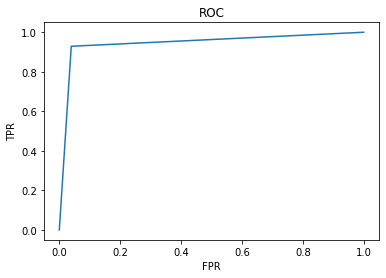

In [9]:
print("\nCalculating AUC, EER, TPR, FPR, Threshold of train dataset...\n")
auc, eer, tpr, fpr, thres = eva.get_metrics(train_reserve_for_cal, train_label_for_cal)
print("AUC = ", auc)
print("EER = ", eer)
print("TPR = ", tpr)
# print(tpr.shape)
print("FPR = ", fpr)
# print(fpr.shape)
# print("Threshold = ", thres)

train_acc = get_acc(train_reserve_for_cal, train_label_for_cal)
print("ACC = ", train_acc)

plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.savefig("train_ROC.png")
plt.show()

In [10]:
"""
    test/
    测试集
    所有不随循环消亡的变量均带test_前缀
"""

# 创建输出文件
test_output = open("test_output.txt", "w")

# 定义测试集语音路径
test_wav_path = "../vad/wavs/test"

# 读取测试集文件夹
test_files = os.listdir(test_wav_path)

# 用于计算AUC、EER、ROC等指标的变量，不随循环消亡
test_reserve_for_cal = []
test_label_for_cal = []

for file in test_files:
    # 读取语音
    sample_rate, wav_data = wavfile.read(test_wav_path + "/" + file)
    # print("Processing " + test_wav_path + "/" + file)

    # MFCC
    vectors = psf.base.mfcc(wav_data, sample_rate, 0.032, 0.008)

    # 计算帧数
    L = len(wav_data)
    num_of_steps = np.asarray(np.ceil((L - 512) / 128) + 1, dtype=int)

    # 计算两个模型下的scores
    voice_score_samples = np.array(voice_gmm.score_samples(vectors))
    non_score_samples = np.array(nonvoice_gmm.score_samples(vectors))
    
    # 定义并初始化保存单个wav文件中各帧prediction的list
    result = []

    # 取大
    for i in range(len(voice_score_samples)):
        if voice_score_samples[i] >= non_score_samples[i]:
            result.append(1)
            test_reserve_for_cal.append(1)
        else:
            result.append(0)
            test_reserve_for_cal.append(0)

    # test_label是保存单个wav文件VAD label的list
    test_label = []
    test_label = vad.prediction_to_vad_label(result)
    test_output.write(file[0:-4] + " " + test_label + "\n")

test_output.close()
print("\nComplete!\nResult file generated as test_output.txt\n")



Complete!
Result file generated as test_output.txt

